<a href="https://colab.research.google.com/github/aseddin/F22_ECE4715/blob/main/10_ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning

Aggregating the results of several different estimators (i.e. classifiers or regressors) often results in better performance than the best individual estimator. This technique is called ensemble learning and there are different ways to implement it.

For example, you can train a group of decision trees on different subsets of the training set (the different subsets are randomly selected). The outputs from all trees can then be aggregated (i.e. average or mode) to obtain a better output. This group of decision trees is called a _random forest_ and is one of the most powerful ML algorithms.

In [1]:
# code to set things up

# importing common libraries
import numpy as np
import pandas as pd

# Things related to figures and plots
# make figures look nicer
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# figure saving function
from pathlib import Path
IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers

A voting classifier is an ensemble method where different classifiers are trained using the same training set. The predicitions of all classifiers are then aggregated to obtain a better overall classifier. The aggregation can by a simple majority-vote where the most predicted class wins (this is called _hard voting_)

The figures below show a visual illustration of a voting classifier (from Geron's Hands-On ML 3rd edition)

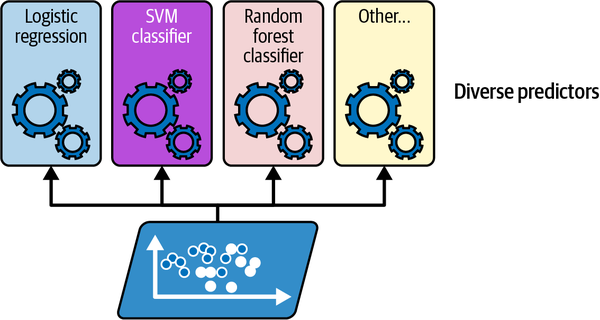

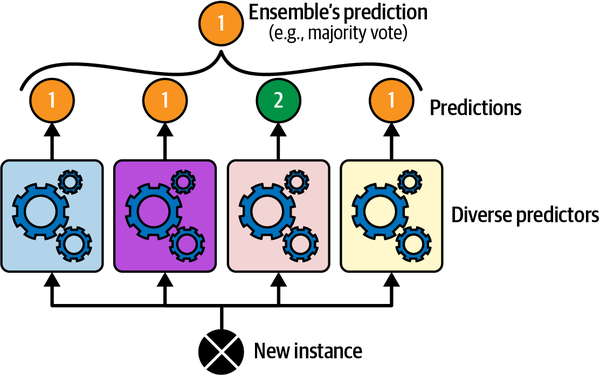

This voting classifier can achieve higher accuracy than the best classifier in the ensemble. This is also possible if each of the classifiers is a _weak learner_ performing slightly better than random guessing (accuracy slightly over 50%). The voting classifier will be a _strong learner_ with accuracy much higher than random (much higher than 50% accuracy). However, there must be a sufficient number of diverse weak learners in the ensemble.

This concept can be explained using Binomial $(n, p)$ random variables. Recall the PMF of a Binomial random variable is given by:
$$
P_X(x) = \binom{n}{x} p^{x} (1 - p)^{(n - x)}
$$
Assume that you have a slightly biased coin with probability $p=0.51$ of coming up head (Bernoulli trial with succuess probability $p=0.51$). The coin is tossed $n$ times and a success is getting more heads than tails. The probability of success is $P[X > \frac{n}{2}] = 1 - F_X(\frac{n}{2} + 1)$ (recall that $F_X(x)$ is the CDF of $X$)

The following shows this computation:

In [2]:
from scipy.stats import binom

p = 0.51
n = 1000

p_success = 0
X = binom(n, p)
p_success = X.sf(n//2) # 1 - cdf(n//2)
print(p_success) 

0.7260985557304961


The more coin tosses, the higher the probability of success (getting more heads than tails)

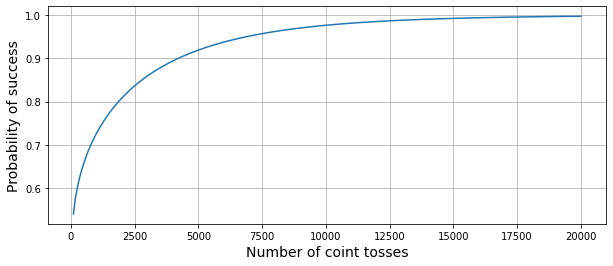

In [3]:
p = 0.51
max_n = 20000

tosses = np.arange(100, max_n, 4)
probabilities = []

for n in tosses:
  p_success = 0
  X = binom(n, p)
  p_success = X.sf(n//2)
  probabilities.append(p_success)

plt.figure(figsize=(10, 4))
plt.plot(tosses, probabilities)
plt.xlabel("Number of coint tosses")
plt.ylabel("Probability of success")
plt.grid()
plt.show()

We can observe the same result by simulating `trials_n` coin tosses and observing the ratio of heads to tails. Again, the more coin tosses the closer the ratio to the actual head probability (law of large numbers)

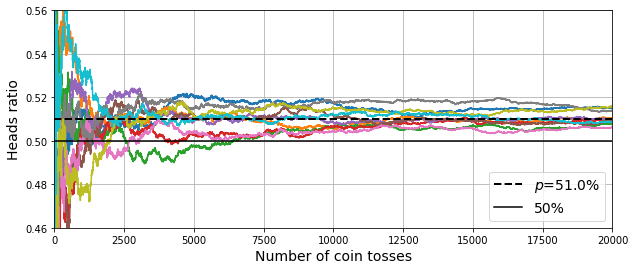

In [4]:
trials_n = 10

coin_tosses = (np.random.rand(max_n, trials_n) < p).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, max_n + 1).reshape(-1, 1)

plt.figure(figsize=(10, 4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, max_n], [p, p], "k--", linewidth=2, label=f"$p$={p*100}%")
plt.plot([0, max_n], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, max_n, p - 0.05, p + 0.05])
plt.grid()
plt.show()

Going back to the voting classifier, each coin toss can be thought of as one of the ensemble's weak learner (accuracy $p=0.51$), the more weak learners the higher the probability of obtaining the correct classification from the ensemble.

**Note**: Bionmial distribution assumes the Bernoulli trials are independent. However, the different classifiers within the ensemble are clearly not independent because they are trained using the same training set. So they will probably make the same types of errors. This means the ensemble's accuracy will not be as high as hoped for but it will still be better than the individual estimators.

## Voting classifiers in `sklearn`

### Hard Voting

Utilizes the predicted classes from each individual classifier in the ensemble

In [5]:
# helper functions

def plot_dataset(X, y, axes):
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
  plt.axis(axes)
  plt.grid(True)
  plt.xlabel("$x_1$")
  plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
  x1s = np.linspace(axes[0], axes[1], 100)
  x2s = np.linspace(axes[2], axes[3], 100)
  x1, x2 = np.meshgrid(x1s, x2s)
  X = np.c_[x1.ravel(), x2.ravel()]
  y_pred = clf.predict(X).reshape(x1.shape)
  plt.contourf(x1, x2, y_pred, cmap=plt.cm.brg, alpha=0.2)
  plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)

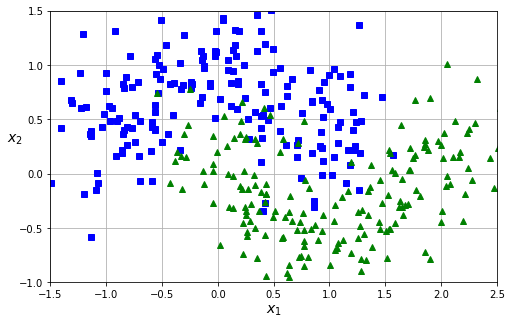

In [6]:
# Make two interleaving half circles

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 5))
plot_dataset(X_train, y_train, [-1.5, 2.5, -1, 1.5])
plt.show()

In [7]:
# building a voting classifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [8]:
# Inividual classifiers prediction
i = 0
X_t = X_test[i].reshape(1, -1)
for name, clf in voting_clf.named_estimators_.items():
  print(name, "=", clf.predict(X_t))

lr = [1]
rf = [1]
svc = [0]


In [9]:
# Voting classifer ensemble prediction on a test instance
voting_clf.predict(X_t)

array([1])

In [10]:
# actual class
y_test[i]

1

In [11]:
# show the test accuracy of the individual classifiers within the ensemble

for name, clf in voting_clf.named_estimators_.items():
  print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [12]:
# show the test accuracy of the voting classifier
print("Voting =", voting_clf.score(X_test, y_test))

Voting = 0.912


The voting classifier has higher accuracy than its individual classifiers

### Soft Voting

If all individual classifiers within the ensemble produces a prediction probability (i.e. it has `predict_proba()`). Then the probabilities from the classifiers can be averaged and the class with the highest averaged probability will be the predicted class. This is called soft voting and it often results in better performance than hard voting because it gives more weight to highly confident votes (i.e. some classifiers within the ensemble will have higher/lower probabilities depending on thier confidence)

In [13]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True #SVC doesn't generate probability by default
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

Soft voting seems to generate slightly better accuracy than hard voting

# Bagging and Pasting

Voting classifiers are diversified by using different training algorithms in the ensemble. Another approach to diversify the ensemble is to use the same training algorithm for all estimators while training them using different random subsets of the training set. The random training subsets can be generated in two ways:

* ***Bagging (bootstrap aggregating)***: An instance is sampled with replacement. For each estimator's training subset, a training instance is selected randomly then replaced in the original training set. A training instance might appear more than once in an estimator's training subset.
* ***Pasting***: An instance is sampled without replacement. For each estimator's training subset, a training instance is selected randomly and it is no longer available to be sampled again for the same estimator. In other words, a training instance might appear only once in an estimator's training subset.

Please note that a training instance might appear in more than one training subsest for both bagging and pasting. (It might also never appear in any training subset)

Once all estimators are trained using their corresponding training subset, a prediction can be made for a new instance in a simialr way to voting classifiers (hard or soft) (i.e. the class with the most frequent predictions (hard) or the highest averaged probability (soft) wins)

The figure below show a visual illustration of a bagging/pasting classifier (from Geron's Hands-On ML 3rd edition)

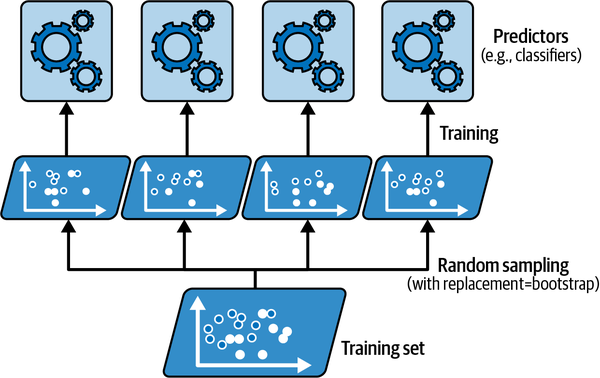

## Bagging and Pasting in `sklearn`

`BaggingClassifier` can be used for:
* **Bagging** by setting `bootstrap=True`
* **Pasting** by setting `bootstrap=False`

`BagginggRegressor` can be used for bagging and pasting regression

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# number of decision trees
n_estimators=500

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=n_estimators,
    max_samples=100, bootstrap=True,
    n_jobs=-1, random_state=42
)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

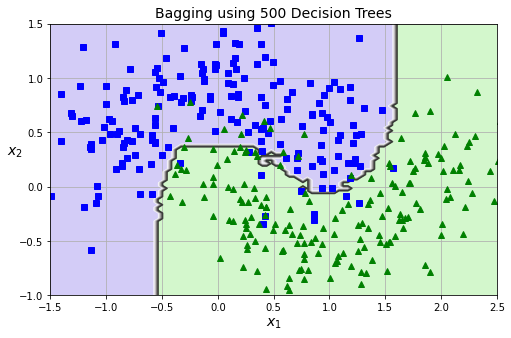

In [15]:
plt.figure(figsize=(8, 5))
plot_dataset(X_train, y_train, [-1.5, 2.5, -1, 1.5])
plot_predictions(bag_clf, [-1.5, 2.5, -1, 1.5])
plt.title("{:s} using {:d} Decision Trees".format("Bagging" if bag_clf.bootstrap else "Pasting", n_estimators))
plt.show()

## Out-of-Bag (OOB) Evaluation

Bagging classifiers might sample a training instance more than once for a particular estimator. For each estimator, however, there will be some instances that will not be sampled. These instances are called out-of-bag (OOB) instances. 

The OOB instances are not the same for each estimator. Given a sufficient number of estimators, each instance in the training set will be an OOB for several estimators. These OOB instances can be used to assess the ensemble's performance without having to create a separate validation set.

In `sklearn` just set `oob_score=True` and access the score using `oob_score_` attribute


In [16]:
# number of decision trees
n_estimators=500

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=n_estimators,
    max_samples=1.0, bootstrap=True,
    n_jobs=-1, random_state=42,
    oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [17]:
# Test score
bag_clf.score(X_test, y_test)

0.92

The oob score seems a bit lower than the actual test score

## Random Patches and Random Subspaces

`BaggingClassifier` also allows feature sampling using two hyperparameters:
* `max_features`: The number of features to sample from the training set for each estimator
* `bootstrap_features`: Whether sampled features are drawn with replacement (baggingg features) or without replacement (pasting features)

These work in the same way as `max_samples` and `bootstrap` but for feature sampling instead of instance sampling. Therefore, each estimator will be trained on a random subset of the input features.

* ***Random Patches*** is when training instances and features are both sampled.
* ***Random Subspaces*** is when all training instances are kept (`bootstrap=False` and `max_samples=1.0`); however, the features are sampled (`bootstrap_features=True` and/or `max_features` is less than 1.0)

# Random Forests

Bagging/Pasting ensembles can have any base estimator (i.e. SVC, Linear Regression, Decision Tree...etc.). If the base estimator is a decision tree you get a random forest. Instead of using `BaggingClassifier`, `sklearn` has a dedicated `RandomForestClassifer` (and `RandomForestRegressor`) that is more convenient and optimized for decision trees.

The `RandomForestClassifier` (with a few exceptions) has all the hyperparameters of `DecisionTreeClassifier` (that gives control over how trees are grown) and all of the hyperparameters of a `BaggingClassifier` (controlling the ensemble).

Random forests are typically trained using bagging (or pasting) with `max_samples=1.0` (so all training subsets have the same size as the original training set). Moreover, the random forest algorithm has extra randomness when growing trees, instead of searching for the best feature when splitting a node, it searches for the best feature among a random subset of features. By default, it samples $\sqrt{n}$ features (where $n$ is the number of input features). Please note that each of the decision trees still has access to all input features, the random subset of features is sampled when a node splits.

In [18]:
# Training a random forest classifier
from sklearn.ensemble import RandomForestClassifier

# number of trees in the forest
n_estimators = 500

rf_clf = RandomForestClassifier(
    n_estimators=n_estimators, max_leaf_nodes=16,
    n_jobs = -1, random_state=42
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

The following bagging ensemble generates the same random forest

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=n_estimators, n_jobs=-1, random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

In [20]:
np.all(y_pred_rf == y_pred_bag)

True

## Feature Importance

Random forests can estimate the relative importance of each input feature. It measures the importance of each feature by considering how much the tree nodes that used a feature reduced impurity on average, across all trees in the forest. The average is weighted using a node's number of samples.

In `sklearn` feature importances are automatically computed and scaled so they sum up to 1.

In [21]:
# Iris feature importance
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42,
                                n_jobs=-1)
rf_clf.fit(iris.data, iris.target)

for score, name in zip(rf_clf.feature_importances_, iris.data.columns):
  print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


It seems that petal length (44%) and petal width (42%) are the most important followed by the less important sepal length (11%) and petal width (2%)

In [22]:
# MNIST feature importance
# most important pixels

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

In [23]:
# Train a random forest classifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_mnist, y_mnist)

RandomForestClassifier(random_state=42)

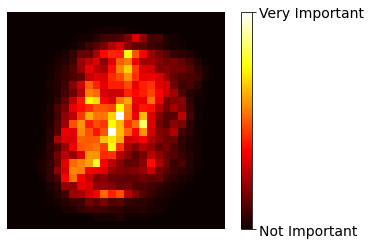

In [24]:
# plot pixel importance heatmap

heatmap_image = rf_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(
    ticks=[rf_clf.feature_importances_.min(),
           rf_clf.feature_importances_.max()]
)
cbar.ax.set_yticklabels(["Not Important", "Very Important"], fontsize=14)
plt.axis("off")
plt.show()


# Boosting

An ensemble method where the general idea is to train several estimators sequentially, where each estimator tries to correct its preecessor.

There are many boosting algorithms, we will cover the most popular:
* AdaBoost 
* Gradient Boosting
* Histogram-Based Gradient Boosting



## AdaBoost

Short for _adaptive boosting_. In this technique, each estimator corrects its predecessor by paying more attention to the training instances that were underfit by the predecessor. So the sequential estimators focus more and more on the difficult cases.

The following figure (from Geron's Hands-On ML 3rd edition) illustrate this technique: 

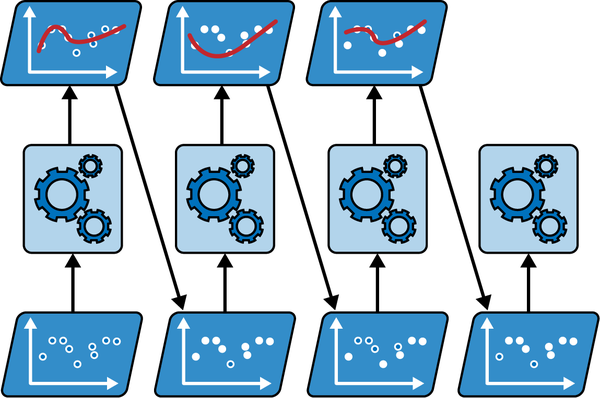

AdaBoost trains a base estimator, then uses the estimator to make predictions on the training set. The instances that were underfit (i.e. misclassified shown in blue-filled circles) will be given more weights, the updated weighted training instances will be used to train a second estimator, and so on.

Once all estimators are trained, the ensemble makes predication by hard or soft voting (similar to bagging and pasting). However, the estimators predictions will be weighted differently depending on each estimator's overall accuracy on the weighted training set.

### The AdaBoost Algorithm

***Training***
* Initialize each instance weight $w^{(i)} = \frac{1}{m}$
* Train a first estimator (i.e. predictor)
* Compute the weighted error rate $r_j$ (where $j=1$ for the first estimator) using
$$
r_j = \sum_{\substack{i=1 \\ \hat{y}_j^{(i)} \neq y^{(i)}}}^{m} w^{(i)}
$$
$\hat{y}_j^{(i)}$ is the $j^{th}$ predictor's predictions for the $i^{th}$ instance
* Compute the predictor's weight $\alpha_j$
$$
\alpha_j = \eta \log{\frac{1 - r_j}{r_j}}
$$
$\eta$ is the learning rate hyperparameter (defaults to 1) 

   * $\alpha_j$ will be high (positive) for more accurate estimators
   * $\alpha_j$ will be close to 0 for estimators guessing randomly
   * $\alpha_j$ will be low (negative) for estimators that are often wrong
* Update the instance weights (boost the weights of misclassified instances)
$$
\text{for } i=1, 2, \dots, m\\
w^{(i)} \leftarrow \begin{cases}
w^{(i)} & \text{if }\hat{y}_j^{(i)} = y^{(i)}\\
w^{(i)}\text{exp}(\alpha_j) & \text{if }\hat{y}_j^{(i)} \neq y^{(i)}\\
\end{cases}
$$
* Normalize all instance weights (divide by $\sum_{i=1}^{m} w^{(i)}$)
* Train a new predictor using the updated weights
* Repeat untill the desired number of estimators is reached or when a perfect estimator is found

***Prediction***

To make a prediction on a new instance:
* Compute the prediction of all estimators
* Weight predictions by thier estimator's weight $\alpha_j$
* The final prediction is the one that receives the majority of weighted votes
$$
\hat{y}(\mathbf{x})= \text{argmax}_k \sum_{\substack{j=1 \\ \hat{y}_j(\mathbf{x})=k}}^{N} \alpha_j
$$
$N$ is the number of estimators

In [25]:
# helper function

# implement an AdaBoost stage
def ada_boost_stage(base_clf, weights, eta):
  base_clf.fit(X_train, y_train, sample_weight=weights * m) # fit a classifier stage
  y_pred = base_clf.predict(X_train) # make predictions
  error_weights = weights[y_pred != y_train].sum()
  r = error_weights / weights.sum() # weighted error rate
  alpha = eta * np.log((1 - r) / r) #predictor's weight
  weights[y_pred != y_train] *= np.exp(alpha) #update instance weights (boosting)
  weights /= weights.sum() #normalize instance weights
  return base_clf, weights, alpha
  

The following code segment shows the decision boundaries of `stages` AdaBoost classifiers

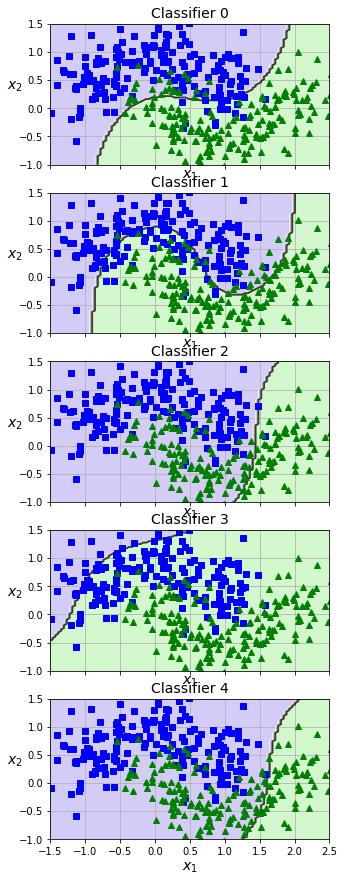

In [26]:
stages = 5
eta = 1
#eta = 0.5

base_clf = SVC(kernel='rbf', gamma=0.6, C=0.2, random_state=42)
m = len(X_train)
initial_weights = np.ones(m) / m
weights = initial_weights

fig, axes = plt.subplots(nrows=stages, ncols=1, figsize=(5, 15), sharex=True)

alphas = []
for stage in range(stages):
  clf, weights, alpha = ada_boost_stage(base_clf, weights, eta)
  plt.sca(axes[stage])
  plot_dataset(X_train, y_train, [-1.5, 2.5, -1, 1.5])
  plot_predictions(clf, [-1.5, 2.5, -1, 1.5])
  plt.title(f"Classifier {stage}")
  alphas.append(alpha)

plt.show()

### AdaBoost in `sklearn`

`AdaBoostClassifier` (and `AdaBoostRegressor`) implements a multiclass version of AdaBoost called _Stagewise Additive Modeling using a Multiclass Exponential loss function_ (SAMME). SAMME is equivalent to AdaBoost for binary classification problems. 

In [27]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

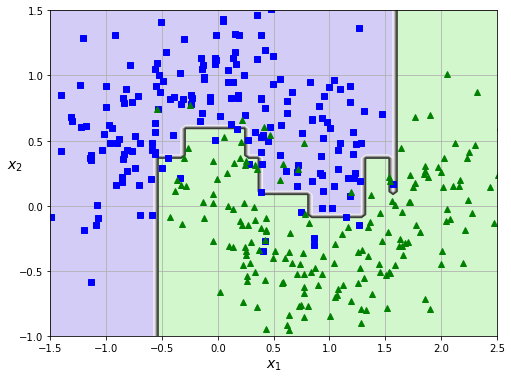

In [28]:
plt.figure(figsize=(8, 6))
plot_dataset(X_train, y_train, [-1.5, 2.5, -1, 1.5])
plot_predictions(ada_clf, [-1.5, 2.5, -1, 1.5])
plt.show()